In [7]:
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
colors = sns.color_palette()

In [8]:
from halotools.empirical_models import HodModelFactory
from halotools.empirical_models import TrivialPhaseSpace, Zheng07Cens
from halotools.empirical_models import NFWPhaseSpace, Zheng07Sats
from halotools.sim_manager import CachedHaloCatalog
from src.redMagicHOD import RedMagicCens, RedMagicSats

In [9]:
simname = 'fox'
version_name = 'most_recent'
rz = 0.0
size = (400.0)**3

cens_prof_model = TrivialPhaseSpace(redshift = rz)
sats_prof_model = NFWPhaseSpace(redshift = rz)

model_instance = HodModelFactory(
        centrals_occupation = RedMagicCens(redshift = rz),
        centrals_profile = cens_prof_model,
        satellites_occupation = RedMagicSats(redshift = rz),
        satellites_profile = sats_prof_model)

halocat= CachedHaloCatalog(simname = simname, halo_finder = 'rockstar',version_name = version_name, redshift = rz)

In [10]:
from halotools.mock_observables import return_xyz_formatted_array
from halotools.utils import group_member_generator
from halotools.mock_observables import mean_y_vs_x

In [23]:
xmin, xmax = 1e11, 1e16
ymin, ymax = 0, 70
halo_mass = np.logspace(np.log10(xmin),np.log10(xmax),100) #bad name, actually mass bins. 
fig = plt.figure(figsize = (15,10))

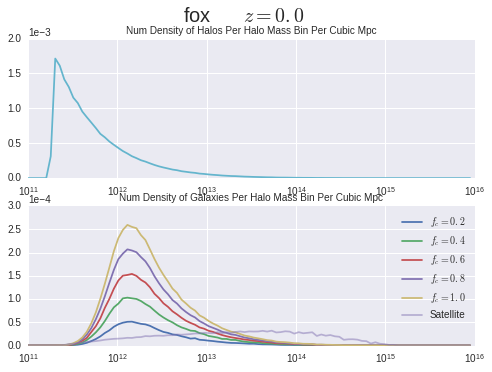

In [25]:
for c, f_c in zip(colors, [0.2, 0.4, 0.6, 0.8, 1.0]):
    model_instance.param_dict['f_c'] = f_c
    model_instance.populate_mock(halocat)

    halos = model_instance.mock.halo_table

    halos.sort(['halo_id', 'halo_upid'])
    grouping_key = 'halo_id'
    requested_columns = ['halo_num_centrals', 'halo_num_satellites', 'halo_mvir']
    group_gen = group_member_generator(halos, grouping_key, requested_columns)

    ncen = []
    nsat = []
    mass = []

    for first, last, member_props in group_gen:

        ncen.append(member_props[0][0])
        nsat.append(member_props[1][0])
        mass.append(member_props[2][0]) 

    ncen = np.array(ncen)
    nsat = np.array(nsat)
    mass = np.array(mass)

    binned_logmass, ncen_hat, ncen_err= mean_y_vs_x(mass, ncen, bins = halo_mass, error_estimator = 'variance')
    binned_logmass, nsat_hat, nsat_err= mean_y_vs_x(mass, nsat, bins = halo_mass, error_estimator = 'variance')

    nhalo_binned, be = np.histogram(mass, halo_mass)
    
    mean_ncen = model_instance.mean_occupation_centrals(prim_haloprop = halo_mass)
    mean_nsat = model_instance.mean_occupation_satellites(prim_haloprop = halo_mass)
    
 

    plt.subplot(212)
    y2, be = np.histogram(mass, bins = halo_mass ,weights=ncen/size )
    plt.plot(be[:-1], y2, color = c, label = '$f_c = %.1f$'%f_c)
    #y3, be = np.histogram(mass, bins = halo_mass ,weights=nsat/size )
    #plt.plot(be[:-1], y3, color = colors[3], label = 'Satellite', alpha = 0.5)

    
plt.subplot(211)
y1, be = np.histogram(mass, bins = halo_mass ,weights=np.ones(mass.shape)/size )
c = colors[5]
plt.plot(be[:-1], y1, color = c)
plt.title("Num Density of Halos Per Halo Mass Bin Per Cubic Mpc",fontsize = 10)
plt.xscale('log')
plt.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
plt.xlim([xmin,xmax])
plt.ylim([0, 2e-3])

plt.subplot(212)
y3, be = np.histogram(mass, bins = halo_mass ,weights=nsat/size )
c = colors[5]
plt.plot(be[:-1], y3, color = colors[3], label = 'Satellite', alpha = 0.5)
plt.title("Num Density of Galaxies Per Halo Mass Bin Per Cubic Mpc",fontsize = 10)
plt.legend(loc = 'best')
plt.xscale('log')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim([xmin,xmax])
plt.ylim([0, 3e-4])

plt.suptitle('%s\t $z = %.1f$'%(simname, rz), fontsize = 20)

plt.show()